In [12]:
from skimage.segmentation import clear_border
#import pytesseract
import numpy as np
import imutils
import cv2
from PIL import Image
import pytesseract
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt


In [13]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'


In [14]:
RectFilter= [(55,50),(40,10), (20,10),(20,5),(13,5),(13,3),(9,1),(7,3),(5,2),(4,3),(3,2),(2,1)]

SquareFilter=[(7,7),(3,3),(1,1)]

In [15]:
from scipy.ndimage.morphology import iterate_structure

class PyImageSearchANPR:    
                             #3,6
                             #1.3,1.6
    def __init__(self, minAR=2, maxAR=6, debug = False):
        
        self.minAR = minAR
        self.maxAR = maxAR
        self.debug = debug

    def debug_imshow(self, title, image, waitKey=False):
        if self.debug:

            cv2.imshow(title,image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

    def locate_license_plate_candidate(self, gray, rec, sqr, keep=5):
        
        image_copy=gray
                                                            #25,10
                                                            #20,5
        rectKern = cv2.getStructuringElement(cv2.MORPH_RECT,rec)
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
        #self.debug_imshow("Blackhat", blackhat)
        
        
                                                               #7,7
                                                               #3,3
        squareKern = cv2.getStructuringElement(cv2.MORPH_RECT,sqr)
        light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
        light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY| cv2.THRESH_OTSU)[1]
        #self.debug_imshow("Light regions", light)
        

        gradX = cv2.Sobel(blackhat, ddepth = cv2.CV_32F, dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX=255*((gradX-minVal)/(maxVal-minVal))
        gradX = gradX.astype('uint8')
        #self.debug_imshow("Scharr", gradX)
        

        gradX = cv2.GaussianBlur(gradX,(5,5),0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
        thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY| cv2.THRESH_OTSU)[1]
        #self.debug_imshow("Grad Thresh", thresh)
        

        thresh = cv2.erode(thresh, None, iterations = 2)
        thresh = cv2.dilate(thresh, None, iterations = 2)
        #self.debug_imshow("Grad Erode/Dilate", thresh)
        

        thresh = cv2.bitwise_and(thresh, thresh, mask = light)
        thresh = cv2.dilate(thresh, None, iterations = 2)
        thresh = cv2.erode(thresh, None, iterations = 1)
        #self.debug_imshow("Final", thresh, waitKey = True)
        
        

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
        
        #print(cnts)
        
        cnts=cnts[:int(keep)]
        
        
        cv2.drawContours(image=image_copy, contours=cnts, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
            
        #cv2.imshow('None approximation', image_copy)
        cv2.waitKey(0)
        cv2.imwrite('contours_none_image1.jpg', image_copy)
        cv2.destroyAllWindows()

            
        return cnts

    def locate_license_plate(self, gray, candidate, clearBorder = False):
        
        lpCnt = None
        roi = None
        #lpCnt = []
        #roi = []

        for c in candidate:


            (x,y,w,h) = cv2.boundingRect(c)
            ar = w/float(h)
            
            #print(ar)

            if ar >= self.minAR and ar <= self.maxAR:
                

                #lpCnt.append(c)
                lpCnt = c
                licensePlate = gray[y:y+h, x:x+w]
                roi=licensePlate
                #roi = cv2.threshold(licensePlate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            # print("type of roi is "+str(type(roi)))
                #if clearBorder:
                    
                    #roi = clear_border(roi)

                #roi.append(thresh)
                #self.debug_imshow("License Plate", licensePlate)
                #self.debug_imshow("ROI", roi, waitKey = True)
                break

        return (roi, lpCnt)

    

    def return_number_plate(self, image, clearBorder = False):
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        candidate = self.locate_license_plate_candidate(gray)
        candidates = self.locate_license_plate_candidates(gray)
        (lp,lpCnt) = self.locate_license_plate(gray, candidate, clearBorder = clearBorder)

        return (lp, lpCnt)
    

    def find_and_ocr(self, image, rec, sqr ,psm=7, clearBorder=False) :
        
        lpText = None
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        candidate = self.locate_license_plate_candidate(gray, rec, sqr)
        #print(candidate)
        (lp, lpCnt) = self.locate_license_plate(gray, candidate, clearBorder = clearBorder)

        if lp is not None :
            
            #lp=return_number_plate(lp,clearBorder = clearBorder)
            options = self.build_tesseract_options(psm=psm)
            lpText = pytesseract.image_to_string(lp, config=options)
           
            
            num=len(lpText)
            #print(num)
            
            #if (len(lpText)==11 or len(lpText==12)):
            
            if (lpText is not None) & (num==11 or num==12):
           # self.debug_imshow("License Plate", lp)   

                return lp
            else:
                pass
        
        
    def build_tesseract_options(self, psm=7):

        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        option = "-c tesseract_chair_whitelist={}".format(alphanumeric)
        option += " --psm {}".format(psm)
        return option

    



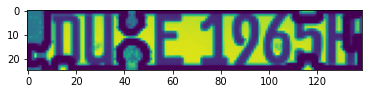

In [16]:
anpr = PyImageSearchANPR(debug = 1)
# imagePath = "/content/1.jpeg"
imagePath = "C:/Digital Engineering/LISCENE PLATE BLUR/Reflection/reflection.jpeg"
image = cv2.imread(imagePath)
image = imutils.resize(image, width = 600)
cv2.imshow('title',image)
cv2.waitKey(0)
cv2.destroyAllWindows()
image = imutils.resize(image, width = 600)
count=1
val=''
final= None
    
for rec in RectFilter:
    for sqr in SquareFilter:
            

        lpText = anpr.find_and_ocr(image, rec, sqr,  psm = 7, clearBorder = 1 )
        
        #print(lpText)
        if lpText is not None:
            final =lpText

plt.imshow(final)

In [17]:
img1= final

In [8]:
anpr = PyImageSearchANPR(debug = 1)
# imagePath = "/content/1.jpeg"
imagePath = "C:/Digital Engineering/LISCENE PLATE BLUR/Reflection/reflection2.jpeg"
image = cv2.imread(imagePath)
image = imutils.resize(image, width = 600)
cv2.imshow('title',image)
cv2.waitKey(0)
cv2.destroyAllWindows()
image = imutils.resize(image, width = 600)
count=0
#val=''
finalImg=None
matchesNumber=0

    
for rec in RectFilter:
    for sqr in SquareFilter:
            

        lpText = anpr.find_and_ocr(image, rec, sqr,  psm = 7, clearBorder = 1 )
        if lpText is not None:
            
            
            #img2 = cv2.cvtColor(lpText, cv2.COLOR_BGR2GRAY)

            #sift
            sift = cv2.xfeatures2d.SIFT_create()

            keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
            keypoints_2, descriptors_2 = sift.detectAndCompute(lpText,None)

            #feature matching
            bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

            matches = bf.match(descriptors_1,descriptors_2)
            matches = sorted(matches, key = lambda x:x.distance)


            #img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
            #plt.imshow(img3),plt.show()
            #print(len(matches))


            if (count > 0 ) & (matchesNumber < len(matches)):
                finalImg= lpText
                matchesNumber=len(matches)
                #print('j')

            elif count==0:
                finalImg=lpText
                matchesNumber=len(matches)
                count=count+1
                
            else:
                #print('g')
                pass


        #print("final")
    #plt.imshow(finalImg)


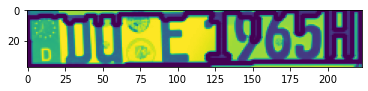

In [9]:
plt.imshow(finalImg)

In [25]:
anpr = PyImageSearchANPR(debug = 1)
# imagePath = "/content/1.jpeg"
imagePath = "C:/Digital Engineering/LISCENE PLATE BLUR/Reflection/reflection2.jpeg"
image = cv2.imread(imagePath)
image = imutils.resize(image, width = 600)
cv2.imshow('title',image)
cv2.waitKey(0)
cv2.destroyAllWindows()
image = imutils.resize(image, width = 600)
count=0
#val=''
finalImg=None
matchesNumber=0

    
for rec in RectFilter:
    for sqr in SquareFilter:
            

        lpText = anpr.find_and_ocr(image, rec, sqr,  psm = 7, clearBorder = 1 )
        if lpText is not None:
            
            
            #img2 = cv2.cvtColor(lpText, cv2.COLOR_BGR2GRAY)

            #sift
            sift = cv2.xfeatures2d.SIFT_create()

            keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
            #print(keypoints_1)
            keypoints_2, descriptors_2 = sift.detectAndCompute(lpText,None)
            #print('ggggggggggggggggggggggggggggggggggggggggggg')
            #print(keypoints_2)

            #feature matching
            bf = cv2.BFMatcher()

            matches = bf.match(descriptors_1,descriptors_2)
            matches = sorted(matches, key = lambda x:x.distance)
            
            matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
            # Apply ratio test
            good = []
            for m,n in matches:
                if m.distance < 0.90*n.distance:
                    good.append([m])
            
        
            # cv.drawMatchesKnn expects list of lists as matches.
            #img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


            #img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
            #plt.imshow(img3),plt.show()
            #print(len(matches))


            if (count > 0 ) & (matchesNumber < len(good)):
                finalImg= lpText
                matchesNumber=len(good)
                #print('j')

            elif count==0:
                finalImg=lpText
                matchesNumber=len(good)
                count=count+1
                
            else:
                #print('g')
                pass


        #print("final")
    #plt.imshow(finalImg)












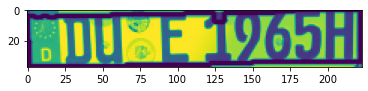

In [26]:
plt.imshow(finalImg)